Datos de jugadores:
   person_id first_name     last_name            birthdate  season_exp jersey  \
0      76001       Alaa     Abdelnaby  1968-06-24 00:00:00         5.0     30   
1      76002       Zaid    Abdul-Aziz  1946-04-07 00:00:00        10.0     54   
2      76003     Kareem  Abdul-Jabbar  1947-04-16 00:00:00        20.0     33   
3        949    Shareef   Abdur-Rahim  1976-12-11 00:00:00        13.0      3   
4      76006     Forest          Able  1932-07-27 00:00:00         1.0      6   

  position     team_id  
0  Forward  1610612757  
1   Center  1610612745  
2   Center  1610612747  
3  Forward  1610612763  
4    Guard  1610612755  

Datos salariales:
   player_id          full_name    Salary  Age   PTS  is_active     Team
0     201939      Stephen Curry  48070014   34  29.4          1      GSW
1     202322          John Wall  47345760   32  11.4          1      LAC
2     201566  Russell Westbrook  47080179   34  15.9          1  LAL/LAC
3       2544       LeBron James 

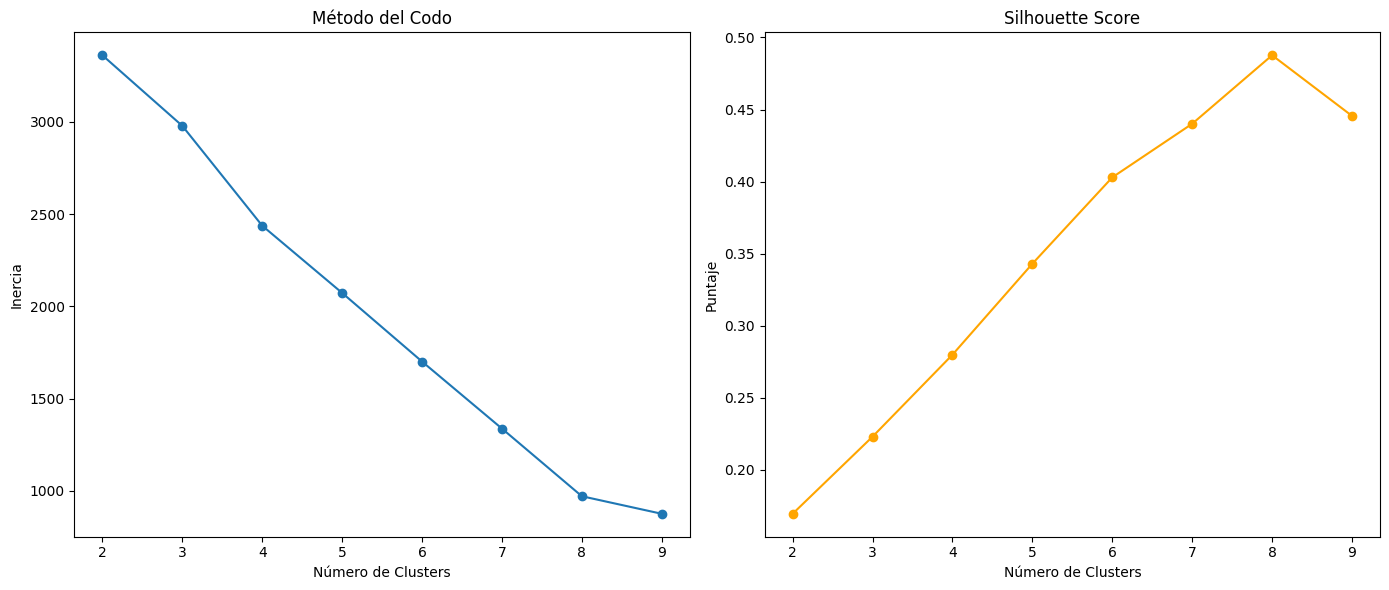

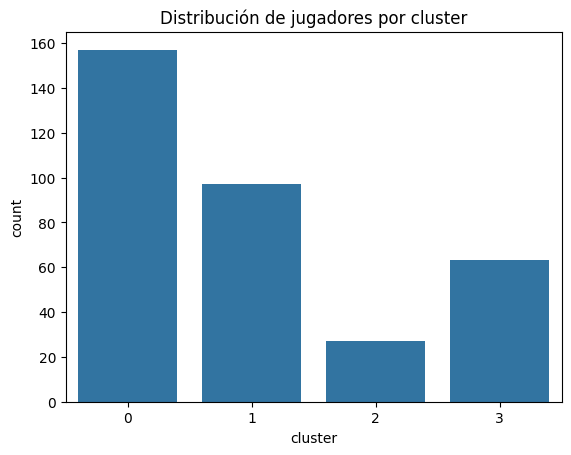

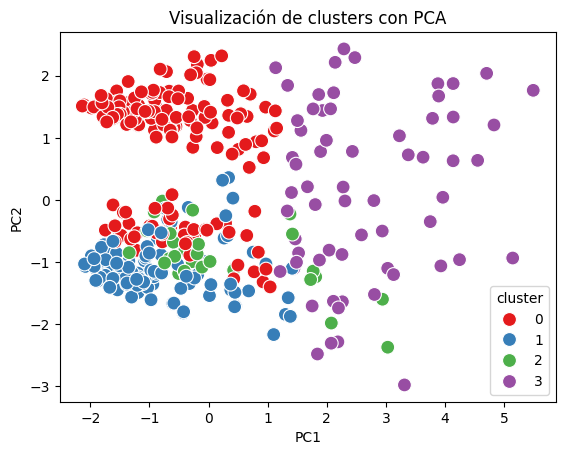


Resumen de clusters:
               Age  season_exp        Salary        PTS    valoracion
cluster                                                              
0        24.121019    3.681529  4.013801e+06   7.298726  5.749850e-06
1        24.432990    3.628866  4.528090e+06   7.447423  3.031495e-06
2        26.851852    5.962963  7.245147e+06   7.459259  1.900052e-06
3        30.698413   10.904762  2.362853e+07  15.739683  7.890067e-07

Top jugadores en el cluster: 0
    first_name  last_name position  Salary   PTS  valoracion
180     Skylar       Mays    Guard  116574  15.3    0.000131
263        Jay     Scrubb    Guard   49719   6.5    0.000131
323    Lindell  Wigginton    Guard   99438   7.1    0.000071
299    Stanley      Umude    Guard   58493   2.0    0.000034
135    Quenton    Jackson    Guard  219630   6.2    0.000028
------------------------------------------------------------

Top jugadores en el cluster: 1
    first_name   last_name position  Salary  PTS  valoracion
277   

In [ ]:
#!/usr/bin/env python
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def load_data():
    db_path = # Ingresa el path de base de datos
    conn = sqlite3.connect(db_path)
    # Cargar tablas relevantes para el análisis
    players_query = "SELECT * FROM common_player_info"
    players_df = pd.read_sql_query(players_query, conn)
    game_query = "SELECT * FROM game"
    game_df = pd.read_sql_query(game_query, conn)
    salary_query = "SELECT * FROM nba_salaries"
    salary_df = pd.read_sql_query(salary_query, conn)
    conn.close()
    return players_df, game_df, salary_df

def suggest_players_by_position(data, required_positions):
    recommendations = {}
    for pos in required_positions:
        # Filtrar jugadores cuya posición limpia coincida (sin considerar mayúsculas)
        subset = data[data['position_clean'].str.lower() == pos.lower()]
        if subset.empty:
            recommendations[pos] = None
        else:
            # Se elige al jugador con mayor "valoracion" (PTS/Salary) dentro del subset
            candidate = subset.sort_values('valoracion', ascending=False).iloc[0]
            recommendations[pos] = candidate
    return recommendations

def main():
    # Conectar a la base de datos y cargar las tablas relevantes
    db_path = # Ingresa el path de base de datos
    conn = sqlite3.connect(db_path)
    
    query_player = """
    SELECT person_id, first_name, last_name, birthdate, season_exp, jersey, position, team_id
    FROM common_player_info
    """
    players_df = pd.read_sql_query(query_player, conn)
    
    query_salary = """
    SELECT player_id, full_name, Salary, Age, PTS, is_active, Team
    FROM nba_salaries
    """
    salary_df = pd.read_sql_query(query_salary, conn)
    
    conn.close()
    
    print("Datos de jugadores:")
    print(players_df.head())
    print("\nDatos salariales:")
    print(salary_df.head())
    
    # Unir las tablas usando sus identificadores; convertir identificadores a numérico
    players_df['person_id'] = pd.to_numeric(players_df['person_id'], errors='coerce')
    salary_df['player_id'] = pd.to_numeric(salary_df['player_id'], errors='coerce')
    data = pd.merge(players_df, salary_df, left_on='person_id', right_on='player_id', how='inner')
    
    print("\nValores nulos en el DataFrame combinado:")
    print(data.isnull().sum())
    data = data.dropna(subset=['Salary', 'PTS'])
    
    # Asegurarse de que las columnas críticas son numéricas y estandarizar la columna de posición
    data['Salary'] = pd.to_numeric(data['Salary'], errors='coerce')
    data['PTS'] = pd.to_numeric(data['PTS'], errors='coerce')
    data['season_exp'] = pd.to_numeric(data['season_exp'], errors='coerce')
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
    data['position_clean'] = data['position'].astype(str).str.strip()
    
    # Aplicar one-hot encoding a la posición para el clustering
    positions_dummies = pd.get_dummies(data['position_clean'], prefix='pos')
    
    # Selección de variables cuantitativas representativas: edad, experiencia, salario y rendimiento (PTS)
    features = data[['Age', 'season_exp', 'Salary', 'PTS']].copy()
    features = pd.concat([features, positions_dummies], axis=1)
    print("\nVista previa del conjunto de características:")
    print(features.head())
    
    # Estandarizar las variables para el clustering
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Elegir el número de clusters con el método del codo y Silhouette Score
    inertia = []
    silhouette_scores = []
    K_range = range(2, 10)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)
        labels = kmeans.labels_
        score = silhouette_score(features_scaled, labels)
        silhouette_scores.append(score)
    
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(K_range, inertia, marker='o')
    ax[0].set_title('Método del Codo')
    ax[0].set_xlabel('Número de Clusters')
    ax[0].set_ylabel('Inercia')
    ax[1].plot(K_range, silhouette_scores, marker='o', color='orange')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Número de Clusters')
    ax[1].set_ylabel('Puntaje')
    plt.tight_layout()
    plt.show()
    
    optimal_clusters = 4
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(features_scaled)
    
    sns.countplot(x='cluster', data=data)
    plt.title("Distribución de jugadores por cluster")
    plt.show()
    
    pca = PCA(n_components=2)
    components = pca.fit_transform(features_scaled)
    data['PC1'] = components[:, 0]
    data['PC2'] = components[:, 1]
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=data, palette='Set1', s=100)
    plt.title("Visualización de clusters con PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    # Calcular la métrica "valoracion" (PTS/Salary) para evaluar eficiencia
    data['valoracion'] = data['PTS'] / (data['Salary'] + 1e-6)
    cluster_summary = data.groupby('cluster')[['Age', 'season_exp', 'Salary', 'PTS', 'valoracion']].mean()
    print("\nResumen de clusters:")
    print(cluster_summary)
    
    clusters = sorted(data['cluster'].unique())
    for cl in clusters:
        print("\nTop jugadores en el cluster:", cl)
        cluster_data = data[data['cluster'] == cl]
        top_players = cluster_data.sort_values('valoracion', ascending=False).head(5)
        print(top_players[['first_name', 'last_name', 'position', 'Salary', 'PTS', 'valoracion']])
        print("-" * 60)
    
    # Posiciones requeridas con sus equivalentes en español (usamos las posiciones en inglés, ya que están en la base)
    # Requeridas: Guard-Forward, Forward-Center, Forward-Guard, Guard, Forward, Center, Center-Forward
    required_positions = ["Guard-Forward", "Forward-Center", "Forward-Guard", "Guard", "Forward", "Center", "Center-Forward"]
    
    recommendations = suggest_players_by_position(data, required_positions)
    
    print("\nRecomendaciones por posición:")
    for pos in required_positions:
        print(f"\nPosición: {pos} (Recomendación)")
        candidate = recommendations.get(pos)
        if candidate is not None:
            print("Jugador sugerido:")
            # Mostrar información detallada: nombre, cluster, posición, edad, experiencia, salario, PTS y valoracion
            details = candidate[['first_name', 'last_name', 'position', 'cluster', 'Age', 'season_exp', 'Salary', 'PTS', 'valoracion']]
            print(details.to_string())
        else:
            print("No se encontró un candidato para esta posición.")
    
    # Opcional: Sistema de recomendación basado en vecinos cercanos para un jugador de referencia
    neighbors_model = NearestNeighbors(n_neighbors=5, metric='euclidean')
    neighbors_model.fit(features_scaled)
    def recomendar_jugadores(player_identifier, data_df, features_scaled, n_recommend=5):
        idx_array = data_df.index[data_df['player_id'] == player_identifier]
        if len(idx_array) == 0:
            print("Jugador no encontrado.")
            return None
        idx = idx_array[0]
        jugador_feature = features_scaled[idx].reshape(1, -1)
        distances, indices = neighbors_model.kneighbors(jugador_feature, n_neighbors=n_recommend+1)
        indices = indices.flatten()
        indices = indices[indices != idx]
        recomendaciones = data_df.iloc[indices]
        return recomendaciones
    ref_player_id = 201939
    print("\nRecomendaciones similares para el jugador con player_id =", ref_player_id)
    recs = recomendar_jugadores(ref_player_id, data, features_scaled, n_recommend=5)
    if recs is not None:
        print(recs[['first_name','last_name','position','cluster','Age','season_exp','Salary','PTS']])
    
if __name__ == '__main__':
    main()